## install pacakges

In [ ]:
import os
import zipfile
import csv

import requests


def _download(url: str, dest_path: str):

    req = requests.get(url, stream=True)
    req.raise_for_status()

    with open(dest_path, "wb") as fd:
        for chunk in req.iter_content(chunk_size=2 ** 20):
            fd.write(chunk)


def get_data():

    ratings_url = ("http://www2.informatik.uni-freiburg.de/" "~cziegler/BX/BX-CSV-Dump.zip")

    if not os.path.exists("data"):
        os.makedirs("data")

        _download(ratings_url, "data/data.zip")

    with zipfile.ZipFile("data/data.zip") as archive:
        return (
            csv.DictReader(
                (x.decode("utf-8", "ignore") for x in archive.open("BX-Book-Ratings.csv")),
                delimiter=";",
            ),
            csv.DictReader(
                (x.decode("utf-8", "ignore") for x in archive.open("BX-Books.csv")), delimiter=";"
            ),
        )


def get_ratings():

    return get_data()[0]


def get_book_features():

    return get_data()[1]

In [ ]:
import json
from itertools import islice

ratings, book_features = get_data()

In [ ]:
for line in islice(ratings, 2):
    print(json.dumps(line, indent=4))

In [ ]:
for line in islice(book_features, 1):
    print(json.dumps(line, indent=4))

In [ ]:
from lightfm.data import Dataset

dataset = Dataset()
dataset.fit((x['User-ID'] for x in get_ratings()),
            (x['ISBN'] for x in get_ratings()))

num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

dataset.fit_partial(items=(x['ISBN'] for x in get_book_features()),
                    item_features=(x['Book-Author'] for x in get_book_features()))

(interactions, weights) = dataset.build_interactions(((x['User-ID'], x['ISBN'])
                                                      for x in get_ratings()))

print(repr(interactions))

In [ ]:
item_features = dataset.build_item_features(((x['ISBN'], [x['Book-Author']])
                                              for x in get_book_features()))
print(repr(item_features))

In [1]:
!pip install pandas==0.21
!pip install tqdm 
!pip install lightfm

!pip install loguru

## load data

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from loguru import logger
import argparse
import multiprocessing






parser = argparse.ArgumentParser(description='t')
parser.add_argument('--now_phase', type=int, default=6, help='')
parser.add_argument('--window', type=int, default=10, help='cocur_matr的时间窗')
parser.add_argument('--time_decay', type=float, default=7/8, help='时间衰减')
parser.add_argument('--mode', type=str, default='train', help='train test')
parser.add_argument('--topk', type=int, default=500, help='每种召回策略召回的样本数')
parser.add_argument('--DATA_DIR', type=str, default='./', help='data dir')

args = parser.parse_args(args=[])
trace = logger.add(os.path.join(args.DATA_DIR, 'data_gen/runtime.log'))

# Cell
def load_click_data_per_phase(now_phase, base_dir):
    """
    """


    all_click_df = []
    for c in range(now_phase + 1):
        logger.info(f'phase: {c}')
        cols_str = 'user_id item_id time'.split()
        click_train1 = pd.read_csv( './underexpose_train_click-{}.csv'.format(c), header=None,  names=['user_id', 'item_id', 'time'], converters={c: str for c in cols_str})
        click_test1 = pd.read_csv( './underexpose_test_click-{}.csv'.format(c, c), header=None,  names=['user_id', 'item_id', 'time'], converters={c: str for c in cols_str})
        test_qtime1 = pd.read_csv( './underexpose_test_qtime-{}.csv'.format(c, c), header=None,  names=['user_id','time'], converters={c: str for c in cols_str})
        click_test1_val = click_test1.sort_values(['user_id', 'time']).drop_duplicates(subset=['user_id'],keep='last')

        click_test1 = click_test1[~click_test1.index.isin(click_test1_val.index)]
        all_click = click_train1.append(click_test1).drop_duplicates().sort_values('time')

        all_click_df.append((all_click, click_test1_val, test_qtime1))
        logger.info(f'all_click: {all_click.shape}, click_test1_val: {click_test1_val.shape}, test_qtime1: {test_qtime1.shape}')
    return all_click_df
all_click_df = load_click_data_per_phase(args.now_phase, args.DATA_DIR)
all_train=pd.concat([all_click_df[i][0] for i in range(0,7)]).drop_duplicates().reset_index(drop=True)
all_train=all_train.sort_values(by=['user_id','time'],ascending=['True','False'])






2020-06-05 01:50:03.367 | INFO     | __main__:load_click_data_per_phase:36 - phase: 0
2020-06-05 01:50:04.574 | INFO     | __main__:load_click_data_per_phase:47 - all_click: (261337, 3), click_test1_val: (1663, 3), test_qtime1: (1663, 2)
2020-06-05 01:50:04.575 | INFO     | __main__:load_click_data_per_phase:36 - phase: 1
2020-06-05 01:50:05.663 | INFO     | __main__:load_click_data_per_phase:47 - all_click: (264871, 3), click_test1_val: (1726, 3), test_qtime1: (1726, 2)
2020-06-05 01:50:05.664 | INFO     | __main__:load_click_data_per_phase:36 - phase: 2
2020-06-05 01:50:06.760 | INFO     | __main__:load_click_data_per_phase:47 - all_click: (264624, 3), click_test1_val: (1690, 3), test_qtime1: (1690, 2)
2020-06-05 01:50:06.761 | INFO     | __main__:load_click_data_per_phase:36 - phase: 3
2020-06-05 01:50:07.949 | INFO     | __main__:load_click_data_per_phase:47 - all_click: (286609, 3), click_test1_val: (1675, 3), test_qtime1: (1675, 2)
2020-06-05 01:50:07.952 | INFO     | __main__:lo

In [3]:
col_name=['item_id']
for i in range(0,128):
    col_name.append('tv'+str(i))
for i in range(0,128):
    col_name.append('iv'+str(i))
itemft=pd.read_csv('./underexpose_item_feat.csv',low_memory=False,names=col_name)
itemft=itemft.replace('[\[\]]','',regex=True)#regex=True is the key
itemft=itemft.astype({'item_id':int, 'tv0':float, 'tv127':float, 'iv0':float, 'iv127':float})

In [4]:
userft=pd.read_csv('./underexpose_user_feat.csv',low_memory=False,names=['user_id','age','gender','city'],dtype=\
                  {'user_id': int,'age':'object','gender':'object','city':'object'})


In [5]:
# user feat have duplicated user ids
a=userft.user_id.value_counts()
dup_user_id=a[a>1].index.tolist()
dup_index=userft.loc[userft.user_id.isin(dup_user_id),:].index.tolist()
dup_index=[i for i in dup_index if i%2 == 0]
userft.drop(dup_index,inplace=True)

## get a phase

In [6]:
all_train=all_click_df[6][0].astype(float)
all_test=all_click_df[6][1].astype(float)

## prepare train test coo_matrix

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
all_train.shape

(337339, 3)

In [20]:
all_test.shape
all_test=all_test[(all_test['user_id'].isin(all_train['user_id'])) & (all_test['item_id'].isin(all_train['item_id']))]
all_test.shape

(1821, 3)

(1821, 3)

In [22]:
le_cols=['item_id','user_id']
encoded_train=dict()
encoded_test=dict()
for key in le_cols:
    le=LabelEncoder()
    encoded_train[key]=le.fit_transform(all_train[key].values)
    encoded_test[key]=le.transform(all_test[key].values)

In [23]:
encoded_train

{'item_id': array([28564, 28838, 39475, ..., 16177,  8617, 46694]),
 'user_id': array([ 8240, 17391,  1965, ..., 18781,  7473,  6533])}

In [25]:
n_users,n_items=len(np.unique(encoded_train['user_id'])),len(np.unique(encoded_train['item_id']))

n_users,n_items

train_codata=np.ones(shape=(all_train.shape[0],))
test_codata=np.ones(shape=(all_test.shape[0],))

from scipy.sparse import coo_matrix

train = coo_matrix((train_codata,(encoded_train['user_id'],encoded_train['item_id'])),shape=(n_users,n_items))
test = coo_matrix((test_codata,(encoded_test['user_id'],encoded_test['item_id'])),shape=(n_users,n_items))

## prepare userft itemft

In [7]:
user_item_matrix=all_train.pivot_table(index='user_id',columns='item_id',aggfunc=len,fill_value=0)
users=pd.DataFrame(data=list(user_item_matrix.index),columns=['user_id'])
user_features=users.merge(userft,how='left')
user_features.shape[0] == user_item_matrix.shape[0]


items=pd.DataFrame(data=list(user_item_matrix.columns.droplevel(level=0)),columns=['item_id'])
item_features=items.merge(itemft,how='left')
item_features.shape[0] == user_item_matrix.shape[1]


user_features.fillna(0,inplace=True)
item_features.fillna(0,inplace=True)

user_features.info()
item_features.info()

user_features=user_features.replace({'M':1,'F':0})

user_features=user_features.astype({'user_id':int,'age':int,'gender':int,'city':int})

user_features.set_index('user_id',inplace=True)
item_features.set_index('item_id',inplace=True)

user_features.dropna().shape
user_features.shape
item_features.dropna().shape
item_features.shape


from scipy.sparse import csr_matrix
uft_csr=csr_matrix(user_features.values)
ift_csr=csr_matrix(item_features.values)
uft_csr.shape
ift_csr.shape



True

True

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20396 entries, 0 to 20395
Data columns (total 4 columns):
user_id    20396 non-null float64
age        20396 non-null object
gender     20396 non-null object
city       20396 non-null object
dtypes: float64(1), object(3)
memory usage: 796.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48664 entries, 0 to 48663
Columns: 257 entries, item_id to iv127
dtypes: float64(257)
memory usage: 95.8 MB


(20396, 3)

(20396, 3)

(48664, 256)

(48664, 256)

(20396, 3)

(48664, 256)

## model

## abort: user feature is too sparse

In [163]:
from lightfm.data import Dataset
# Dataset.build_item_features(data=uft_csr)
from lightfm import LightFM
model=LightFM(learning_rate=5*10**(-10),loss='bpr')
model.fit(coo,user_features=uft_csr,item_features=ift_csr,epochs=3,verbose=True)

Epoch 0


ValueError: Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights

error: ValueError: Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate or normalising feature values and sample weights


In [ ]:
np.isnan(np.min(user_features.values))
np.isnan(np.min(item_features.values))
np.isnan(np.min(user_item_matrix.values[:,1:]))

In [59]:
def fm_eval(coo,prec_k=10,recall_k=100,use='itemft',train_interactions=None,ift_csr=None,t=1):
    from lightfm.evaluation import precision_at_k,auc_score,recall_at_k
    if use == 'itemft':
        train_precision = precision_at_k(model,coo,train_interactions=train_interactions,item_features=ift_csr,k=prec_k,num_threads=t).mean()
        train_auc = auc_score(model,coo,train_interactions=train_interactions,item_features=ift_csr,num_threads=t).mean()
        train_recall=recall_at_k(model,coo,train_interactions=train_interactions,k=recall_k,item_features=ift_csr,num_threads=t).mean()
        print('train: prec: {} with top {},auc: {} , recall: {} with top {}'.format(train_precision,prec_k,train_auc,train_recall,recall_k))
    if use == None:
        train_precision = precision_at_k(model,coo,train_interactions=train_interactions,k=prec_k,num_threads=t).mean()
        train_auc = auc_score(model,coo,train_interactions=train_interactions,num_threads=t).mean()
        train_recall=recall_at_k(model,coo,train_interactions=train_interactions,k=recall_k,num_threads=t).mean()
        print('train: prec: {} with top {},auc: {} , recall: {} with top {}'.format(train_precision,prec_k,train_auc,train_recall,recall_k))

In [13]:
import multiprocessing
num_threads=multiprocessing.cpu_count()

## with no feature

In [ ]:
user_item_matrix.shape
user_item_matrix.fillna(0,inplace=True)
user_item_matrix.dropna().shape

users=pd.DataFrame(data=list(user_item_matrix.index),columns=['user_id'])
user_features=users.merge(userft,how='left')
user_features.shape[0] == user_item_matrix.shape[0]


items=pd.DataFrame(data=list(user_item_matrix.columns.droplevel(level=0))[1:],columns=['item_id'])
item_features=items.merge(itemft,how='left')
item_features.shape[1] == user_item_matrix.shape[1]

user_features.fillna(0,inplace=True)
item_features.fillna(0,inplace=True)

from scipy.sparse import csr_matrix
uft_csr=csr_matrix(user_features.values)
ift_csr=csr_matrix(item_features.values)
uft_csr.shape
ift_csr.shape

user_features.dropna().shape
user_features.shape
item_features.dropna().shape
item_features.shape



from scipy.sparse import coo_matrix
coo=coo_matrix(user_item_matrix.values[:,1:])
coo.shape

### with le constructed train

In [43]:
from lightfm import LightFM
model=LightFM(learning_rate=0.05,loss='bpr')
model.fit(interactions=train,epochs=50,verbose=False,num_threads=num_threads-1,item_features=None)

In [38]:
fm_eval(train,recall_k=1,prec_k=1,use=None)

train: prec: 0.11159050464630127 with top 1,auc: 0.9218184947967529 , recall: 0.010510707295504637 with top 1


In [42]:
fm_eval(train,recall_k=500,prec_k=1,use=None)

train: prec: 0.1086977869272232 with top 1,auc: 0.9098623394966125 , recall: 0.2905786382196576 with top 500


In [40]:
fm_eval(test,train_interactions=train,recall_k=500,prec_k=10,use=None)

train: prec: 0.0007688084151595831 with top 10,auc: 0.6545107364654541 , recall: 0.08896210873146623 with top 500


In [41]:
model.item_biases *= 0.0
fm_eval(test,train_interactions=train,recall_k=1,prec_k=10,use=None)

train: prec: 0.0009884679457172751 with top 10,auc: 0.6510509252548218 , recall: 0.08951125755079627 with top 500


### only on train with simple pivot

In [ ]:
from scipy.sparse import coo_matrix
coo=coo_matrix(user_item_matrix)
coo.shape

In [14]:
from lightfm import LightFM
model=LightFM(learning_rate=0.05,loss='bpr')
model.fit(interactions=coo,epochs=50,verbose=False,num_threads=num_threads-1,item_features=None)
fm_eval(coo,recall_k=1,prec_k=1,use=None)

## with only item feature ***

### with le constructed train

In [71]:
def fm_eval(coo,prec_k=10,recall_k=100,use='itemft',train_interactions=None,ift_csr=None,t=1):
    from lightfm.evaluation import precision_at_k,auc_score,recall_at_k
    if use == 'itemft':
        train_precision = precision_at_k(model,coo,train_interactions=train_interactions,item_features=ift_csr,k=prec_k,num_threads=t).mean()
        train_auc = auc_score(model,coo,train_interactions=train_interactions,item_features=ift_csr,num_threads=t).mean()
        train_recall=recall_at_k(model,coo,train_interactions=train_interactions,k=recall_k,item_features=ift_csr,num_threads=t).mean()
        print('train: prec: {} with top {},auc: {} , recall: {} with top {}'.format(train_precision,prec_k,train_auc,train_recall,recall_k))
    if use == None:
        train_precision = precision_at_k(model,coo,train_interactions=train_interactions,k=prec_k,num_threads=t).mean()
        train_auc = auc_score(model,coo,train_interactions=train_interactions,num_threads=t).mean()
        train_recall=recall_at_k(model,coo,train_interactions=train_interactions,k=recall_k,num_threads=t).mean()
        print('train: prec: {} with top {},auc: {} , recall: {} with top {}'.format(train_precision,prec_k,train_auc,train_recall,recall_k))

In [76]:
model=LightFM(no_components=128,learning_rate=0.02,loss='bpr')
model.fit(train,epochs=30,item_features=ift_csr,verbose=True,num_threads=num_threads-1)


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [77]:
fm_eval(test,train_interactions=train,recall_k=500,prec_k=10,use='itemft',ift_csr=ift_csr,t=num_threads-1)

train: prec: 0.001702361274510622 with top 10,auc: 0.7816762328147888 , recall: 0.17792421746293247 with top 500


In [83]:
def get_mapping_dict(le):
    d={}
    for c in le.classes_:
        d.update({c:le.transform([c])[0]})
    return d


le_cols=['item_id','user_id']
encoded_train=dict()
encoded_test=dict()
for key in le_cols:
    le=LabelEncoder()
    encoded_train[key]=le.fit_transform(all_train[key].values)
    encoded_test[key]=le.transform(all_test[key].values)
    if key=='item_id':
        item_dict=get_mapping_dict(le)
    else:
        user_dict=get_mapping_dict(le)

In [84]:
from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
take(10, user_dict.items())
take(10, item_dict.items())

[(1.0, 0),
 (2.0, 1),
 (3.0, 2),
 (4.0, 3),
 (5.0, 4),
 (7.0, 5),
 (8.0, 6),
 (9.0, 7),
 (10.0, 8),
 (13.0, 9)]

[(3.0, 0),
 (9.0, 1),
 (14.0, 2),
 (16.0, 3),
 (18.0, 4),
 (23.0, 5),
 (28.0, 6),
 (29.0, 7),
 (31.0, 8),
 (32.0, 9)]

## all_predict

In [139]:


recall_frame=pd.DataFrame()
topn=500
item_history=all_train.groupby('user_id')['item_id'].agg(lambda x: list(x))
recall_frame=pd.DataFrame()
topn=500


for user in tqdm(all_test.user_id.unique()):
    user_code=user_dict[user]
    scores=pd.Series(model.predict(user_code,np.arange(n_items),item_features=ift_csr))
    scores.index=user_item_matrix.columns.droplevel(0)
    all_recall = pd.Series(scores.sort_values(ascending=False))
    history = item_history[user]
    recall_items = [x for x in all_recall.index if x not in history][0:topn]
    recall_scores=all_recall.loc[recall_items].values
    n=len(recall_items)

    true_item=list(all_test.loc[all_test.user_id==user].item_id.values)

    df=pd.DataFrame({'rank':range(1,n+1),'user': [user]*n, 'scores':recall_scores,'item_pred':recall_items,'item_true':true_item*n} )
    recall_frame=pd.concat([recall_frame,df])


100%|██████████| 1821/1821 [13:39<00:00,  2.22it/s]


In [142]:
recall_frame

,item_pred,item_true,rank,scores,user
0,81508.0,43173.0,1,8.721670,10005.0
1,21923.0,43173.0,2,8.465993,10005.0
2,94797.0,43173.0,3,8.377849,10005.0
3,885.0,43173.0,4,8.302359,10005.0
4,87621.0,43173.0,5,8.141705,10005.0
5,6879.0,43173.0,6,8.133941,10005.0
6,97241.0,43173.0,7,8.037683,10005.0
7,105419.0,43173.0,8,7.942738,10005.0
8,78507.0,43173.0,9,7.892912,10005.0
9,88028.0,43173.0,10,7.889555,10005.0


In [141]:
sum(recall_frame.item_pred == recall_frame.item_true)/1821

0.17792421746293247

In [144]:
import pickle
with open('./hybrid.pkl','wb') as f:
    pickle.dump(model,f)

In [151]:
recall_frame.to_csv('./fm_recall.csv')

### only on train with simple pivot

In [9]:
from scipy.sparse import coo_matrix
coo=coo_matrix(user_item_matrix)
coo.shape
coo.shape[0] == user_features.shape[0]
coo.shape[1] == item_features.shape[0]
from lightfm import LightFM
model=LightFM(learning_rate=0.05,loss='bpr')
model.fit(coo,epochs=10,item_features=ift_csr,verbose=True,num_threads=num_threads-1)

## plot learning schedule

In [145]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adagrad',
                        user_alpha=alpha,
                        item_alpha=alpha)
adadelta_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adadelta',
                        user_alpha=alpha,
                        item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())


adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())



NameError: name 'plt' is not defined

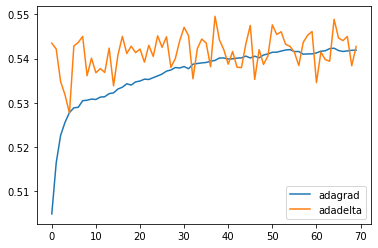

In [150]:
import matplotlib.pyplot as plt
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

In [155]:
import pickle
with open('./user_item_matrix.pkl','wb') as f:
    pickle.dump(user_item_matrix,f,protocol=4)

In [7]:
recall_frame=pd.read_csv('./fm_recall.csv').iloc[:,1:]

In [15]:
recall_50=recall_frame.loc[recall_frame['rank'] <=50]
recall_100=recall_frame.loc[recall_frame['rank']<=100]
recall_500=recall_frame.loc[recall_frame['rank']<=500]


sum(recall_50.item_pred == recall_50.item_true)/1821
sum(recall_100.item_pred == recall_100.item_true )/1821
sum(recall_500.item_pred == recall_500.item_true )/1821



0.04612850082372323

0.07303679297089512

0.17792421746293247